In [63]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyDataset(Dataset):
    def __init__(self, feature_choice):
        current_dir = os.getcwd()

        data_paths = {
            "energies": os.path.join("data", "energies.npy"),
            "2-body": os.path.join("data", "features_2b.npy"),
            "3-body": os.path.join("data", "features_3b.npy"),
            "4-body": os.path.join("data", "features_4b.npy"),
            }
        if feature_choice == "2-body":
            features = np.load(data_paths["2-body"])
        elif feature_choice == "3-body":
            features = np.load(data_paths["3-body"])
        elif feature_choice == "4-body":
            features = np.load(data_paths["4-body"])
        elif feature_choice == "2+3-body":
            features_2 = np.load(data_paths["2-body"])
            features_3 = np.load(data_paths["3-body"])
            features = np.hstack((features_2, features_3))
        elif feature_choice == "4+3-body":
            features_4 = np.load(data_paths["4-body"])
            features_3 = np.load(data_paths["3-body"])
            features = np.hstack((features_4, features_3))
        elif feature_choice == "2+3+4-body":
            features_2 = np.load(data_paths["2-body"])
            features_3 = np.load(data_paths["3-body"])
            features_4 = np.load(data_paths["4-body"])
            features = np.hstack((features_2, features_3, features_4))
        else:
            raise ValueError("Invalid feature choice!")

        features = (features - features.mean())/features.std()
        self.features = features

        energies = np.load(data_paths["energies"])
        energies = (energies - energies.mean())/energies.std()
        self.targets = energies
        
        # Make sure both have the same length
        assert len(self.features) == len(self.targets), "Features and targets must have the same length"

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.features)
    
    def __getitem__(self, index):
        # Retrieve the features and target for the given index
        feature_row = self.features[index]  # Convert to numpy array
        target_value = self.targets[index]  # Convert to numpy array

        # Convert the features to a tensor
        features = torch.tensor(feature_row, dtype=torch.float32)
        
        # Convert the target to a tensor
        target = torch.tensor(target_value, dtype=torch.float32)
        
        return features, target

# Paths to your CSV files
features_file = 'data/features_2b.npy'
targets_file = 'data/energies.npy'

# Create dataset instance
dataset = MyDataset("2-body")

# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        
        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        # Pass input through the hidden layer, followed by ReLU
        x = self.relu(self.hidden(x))
        
        # Pass the result to the output layer
        x = self.output(x)
        
        return x

In [4]:
# Get the number of features in your dataset
input_size = dataset.features.shape[1]  # Number of features in your dataset
hidden_size = input_size  # Size of the hidden layer (you can change this)
output_size = 1  # For regression (single output), set this to 1

# Create the model instance
model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [5]:
# Training function
def train(model, dataloader, loss_fn, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        
        total_loss = 0
        
        for features, targets in dataloader:
            # Forward pass
            outputs = model(features)  # Forward pass through the network
            
            # Compute the loss
            loss = loss_fn(outputs.squeeze(), targets)  # Squeeze to match dimensions if needed
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            total_loss += loss.item()  # Accumulate loss for this batch
        
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")


In [6]:
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    
    predictions = []
    targets = []
    
    with torch.no_grad():  # Disable gradient computation
        for features, target in dataloader:
            output = model(features)  # Forward pass to get predictions
            predictions.append(output)
            targets.append(target)
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    loss = loss_fn(predictions.squeeze(), targets).item()
    return loss


In [66]:
from torch.utils.data import Subset
def simple_NN_graph(dataset, train_sizes = np.logspace(np.log10(0.01), np.log10(1), 2)):
    all_train_errors = []
    all_test_errors = []
    for size in train_sizes:

        # Define the subsample size
        
        # Randomly generate unique indices for the subsample
        random_indices = np.random.choice(dataset.features.shape[0], int(size*dataset.features.shape[0]), replace=False)
        
        # Create a subset using the random indices
        subsample = Subset(dataset, random_indices)

        # Split the dataset        
        train_size = int(size* len(subsample) * 0.8)
        test_size = len(subsample) - train_size
        train_dataset, test_dataset = random_split(subsample, [train_size, test_size])
        
        # Create DataLoaders
        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Get the number of features in your dataset
        input_size = dataset.features.shape[1]  # Number of features in your dataset
        hidden_size = input_size  # Size of the hidden layer (you can change this)
        output_size = 1  # For regression (single output), set this to 1
        
        # Create the model instance
        model = SimpleNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
        
        # Define the loss function and optimizer
        loss_fn = nn.MSELoss()  # Mean Squared Error Loss (for regression)
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

        #train model
        train(model, train_dataloader, loss_fn, optimizer, num_epochs=20)

        #train and test errors
        all_train_errors.append(evaluate(model, train_dataloader))
        all_test_errors.append(evaluate(model, test_dataloader))


    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)
    np.save(f"train_errors_NN_2_body.npy", all_train_errors.T)
    np.save(f"test_errors_NN_2_body.npy", all_test_errors.T)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, all_train_errors, marker = 'o', label="Training Error", color="r")
    plt.plot(train_sizes, all_test_errors, marker = 'o', label="Testing Error", color="g")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for 2 body neural network with 1 hidden layer")
    plt.legend()
    plt.grid()
    plt.show()

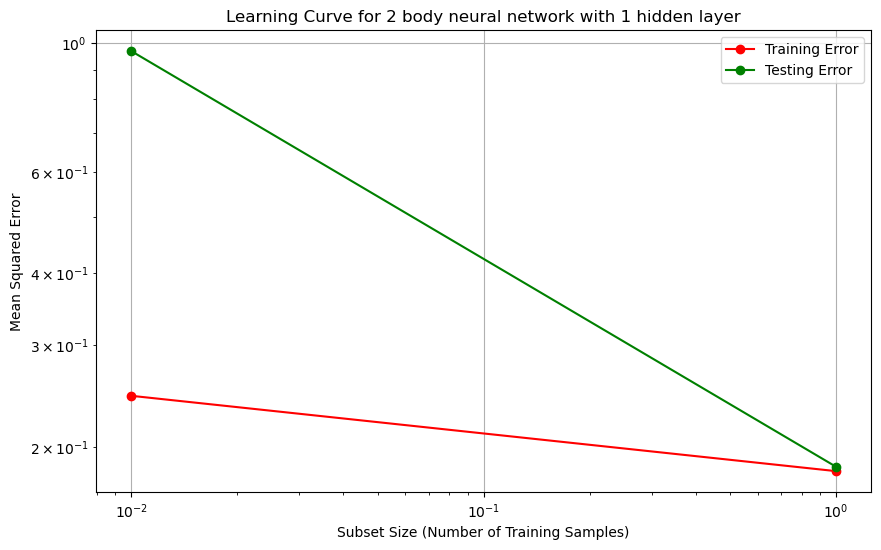

In [67]:
dataset = MyDataset("2-body")
simple_NN_graph(dataset)